In [1]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [15]:
def format_number(num):
    """
    Converts a number into a more readable format, using K for thousands, M for millions, etc.
    Args:
    - num: The number to format.
    
    Returns:
    - A formatted string representing the number.
    """
    if num >= 1e9:
        return f'{num/1e9:.1f}B'
    elif num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.1f}K'
    else:
        return str(num)

def single_barplot(subset, title):
    df_s = df[df.subset==subset]
    n_pos, n_neg = sample_size[subset]
    metric = "AUROC" if n_pos == n_neg else "AUPRC"
    if metric == "AUROC":
        baseline = 0.5
    elif metric == "AUPRC":
        baseline = n_pos / (n_pos + n_neg)
    elif metric == "Odds ratio":
        baseline = 1
    plt.figure(figsize=(2,2))
    g = sns.barplot(
        data=df_s,
        y="Model",
        x=metric,
        order=df_s.sort_values(metric, ascending=False).Model,
        palette=models.color.to_dict(),
    )
    for bar, model in zip(g.patches, df_s.Model):
        text = f'{bar.get_width():.3f}'
        g.text(
            max(bar.get_width(), baseline),  # X position, here at the end of the bar
            bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
            text,  # Text to be displayed, formatted to 3 decimal places
            va='center'  # Vertical alignment
        )
    sample_size_str = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
    g.set_title(f"{title}\n{sample_size_str}", fontsize=10)
    g.set(
        ylabel="",
        xlim=baseline,
    )
    sns.despine();

In [23]:
LLR_version = "LLR"
#LLR_version = "absLLR"

models = pd.DataFrame(
    [
        ["Enformer", "Enformer_L2_L2", "all", "C0"],
        ["Borzoi", "Borzoi_L2_L2", "all", "C1"],
        ["CADD", "CADD", "RawScore", "C2"],
        ["GPN-MSA", f"GPN-MSA_{LLR_version}", "score", "C3"],
        ["GPN", f"GPN_{LLR_version}", "score", "C4"],
        ["NT", f"NucleotideTransformer_{LLR_version}", "score", "C5"],
        ["HyenaDNA", f"HyenaDNA_{LLR_version}", "score", "C6"],
        ["Caduceus", f"Caduceus_{LLR_version}", "score", "C7"],
    ],
    columns=["Model", "path", "feature", "color"]
).set_index("Model")
models

,path,feature,color
Model,,,
Enformer,Enformer_L2_L2,all,C0
Borzoi,Borzoi_L2_L2,all,C1
CADD,CADD,RawScore,C2
GPN-MSA,GPN-MSA_LLR,score,C3
GPN,GPN_LLR,score,C4
NT,NucleotideTransformer_LLR,score,C5
HyenaDNA,HyenaDNA_LLR,score,C6
Caduceus,Caduceus_LLR,score,C7


In [24]:
subsets = [
    "all",
]

dfs = []
sample_size = {}

base_dir = f"../../results/dataset/omim_subsampled_9"
#base_dir = f"../../results/dataset/gwas_matched_9"
#base_dir = f"../../results/dataset/eqtl_matched_1"
V = pd.read_parquet(f"{base_dir}/test.parquet")

for subset in tqdm(subsets):
    s = pd.read_parquet(f"{base_dir}/subset/{subset}.parquet")
    V_s = s.merge(V, on=["chrom", "pos", "ref", "alt"], how="left")
    sample_size[subset] = V_s.label.sum(), (~V_s.label).sum()
    for model in models.index:
        df = pd.read_csv(f"{base_dir}/unsupervised_metrics/{subset}/{models.loc[model, 'path']}.csv")
        df = df[df.feature == models.loc[model, 'feature']].drop(columns=["feature"])
        df["Model"] = model
        df["subset"] = subset
        dfs.append(df)
df = pd.concat(dfs)
df

100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.47it/s]


,AUPRC,Model,subset
1,0.447432,Enformer,all
1,0.448000,Borzoi,all
1,0.598204,CADD,all
0,0.675998,GPN-MSA,all
0,0.312975,GPN,all
0,0.101155,NT,all
0,0.102673,HyenaDNA,all
0,0.093475,Caduceus,all


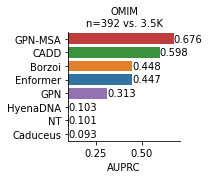

In [25]:
single_barplot("all", "OMIM")

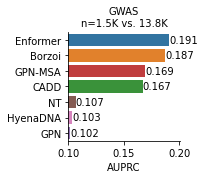

In [20]:
single_barplot("all", "GWAS")

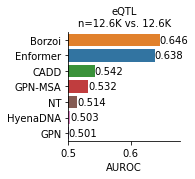

In [22]:
single_barplot("all", "eQTL")